In [477]:
import torch
import sys
sys.path.extend(['..'])
from mvn import MVNIso, create_mog
from distributions import log_prob_mix_laplace as log_p
from util import acf, ess #, estimate_log_z
from math import log, pi, sqrt, exp
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange
import numpy as np
from scipy.integrate import quad
%matplotlib inline

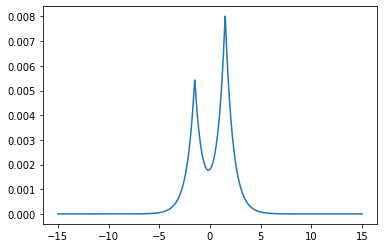

In [478]:
x_grid = torch.linspace(-15, 15, 1500)
discrete_log_p = log_p(x_grid)
discrete_log_p = discrete_log_p - torch.logsumexp(discrete_log_p.flatten(),dim=0)
discrete_p = torch.exp(discrete_log_p)
discrete_p = discrete_p / discrete_p.sum()

plt.plot(x_grid, discrete_p)
plt.show()

## Define a random polynomial

10th order.

In [479]:
torch.manual_seed(42)
random_coeffs = torch.randn(10)
random_poly = np.polynomial.polynomial.Polynomial(random_coeffs)
random_poly
#plt.plot(*random_poly.linspace(100, [-5,5]))

Polynomial([ 0.33669037,  0.1288094 ,  0.23446237,  0.23033303, -1.1228564 ,
       -0.18632829,  2.2082014 , -0.63799703,  0.46165723,  0.26735088],
      dtype=float32, domain=[-1,  1], window=[-1,  1])

Compute the actual expectation under $p^*(x)$ for bias calculations. Use quadrature.

In [480]:
random_poly_expectation, error_est = quad(lambda x: log_p(x*torch.ones(1)).exp() * random_poly(x),
                              -15,
                               15,
                               limit=1000)
random_poly_expectation, error_est

/tmp/ipykernel_19849/3063319930.py:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  random_poly_expectation, error_est = quad(lambda x: log_p(x*torch.ones(1)).exp() * random_poly(x),


(12971.079476281084, 0.0007962899329093231)

## Bias, variance as a function of $\lambda$



Pick a few values of $\lambda$.

In [481]:
# NEED TO GET THESE RANGES BETTER
r=15
configs = [{'lambda': 1.0, 'log_sig_range': (-16, -2), 'mu_range': (-r, r)},]
#            {'lambda': 2.0, 'log_sig_range': (-3, 1.5), 'mu_range': (-r, r)},
#            {'lambda': 8.0, 'log_sig_range': (-2, 1.5), 'mu_range': (-r, r)},
#            {'lambda': 64.0, 'log_sig_range': (-1, 1.5), 'mu_range': (-r, r)}]
for l in np.logspace(0,2,20,)[1:]:
    configs.append({'lambda': l, 'log_sig_range': (-5, 1.5), 'mu_range': (-r, r)})


### Now calculate bias and variance

In [482]:
def sample_theta(psi, n, mm, gg, and_idx=False):
    idx = torch.multinomial(psi.flatten(), num_samples=n, replacement=True)
    if not and_idx: return torch.stack([mm.flatten()[idx], gg.flatten()[idx]], dim=1)
    return torch.stack([mm.flatten()[idx], gg.flatten()[idx]], dim=1), idx
    

def log2prob(logp):
    p = torch.exp(logp - logp.max())
    return p / p.sum()

def log_q(x, theta):
    sig2 = torch.exp(2*theta[1])
    return -0.5*(x.view(-1,1)-theta[0])**2/sig2 - log(2*pi)/2 - theta[1]

In [483]:
def MC_integrate(conf, Neff, fn, plot=False):
    """## Self-normalizing importance sampling integration
    # Propose samples of theta from a big Gaussian or uniform
    # For each theta we calculate log psi with Stam's
    # Then weight the contribution of the integral over that kernel by the proposal dist
    # iterate until the effective sample size reaches Neff
    """
    # todo don't preallocate samples; do online. legacy from before ESS while-loop architecture
    if conf['lambda']>1.1:
        #from a normal dist?
        proposal_p = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(2), 2*torch.eye(2))
        samples = proposal_p.sample([100*Neff])
    else:
        # or from a uniform dist in a box supplied by the ranges?
        proposal_p=None
        samples = torch.rand(100*Neff,2)
        samples[:,0] = samples[:,0]*(conf['mu_range'][1] - conf['mu_range'][0]) + conf['mu_range'][0]
        samples[:,1] = samples[:,1]*(conf['log_sig_range'][1] - conf['log_sig_range'][0]) + conf['log_sig_range'][0]

    q = MVNIso(d=1)
    integral = 0
    curve = torch.zeros_like(x_grid)
    weights = []
    weights2 = []
    sum_weights = 0
    sum_weights2 = 0
    ESS = 0
    i = 0
    while ESS <= Neff and i < 100*Neff:
        sample = samples[i]
        kernel_exp = q.set_theta(sample).quadrature_ev(fn)
        log_psi = get_log_psi(q, conf['lambda'])
        log_prop = 0 if proposal_p is None else proposal_p.log_prob(sample)
        discount = (log_psi - log_prop).exp()
        weights.append(discount)
        weights2.append(discount**2)
        
        if torch.isnan(discount) or torch.isnan(kernel_exp): 
            continue
            
        integral = integral + discount * kernel_exp
        sum_weights += discount
        sum_weights2 += weights2[-1]
        ESS = sum_weights**2 / sum_weights2
        i+=1
        
        if plot: curve += discount * q.to_torch_mvn().log_prob(x_grid[:,None]).exp()

    
    if plot:
        plt.plot(x_grid, curve/sum_weights)
        plt.plot(x_grid, log_p(x_grid).exp(),'r')
        plt.title("EV = {}".format(integral/sum_weights))
        plt.show()
    print("N {} Effective N: {}".format(i,ESS.item()))
    return integral / sum_weights

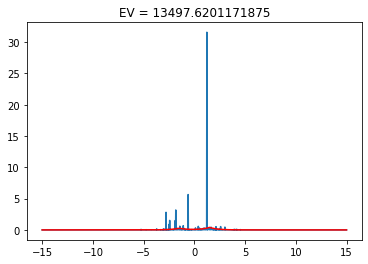

N 5627 Effective N: 1000.6361694335938


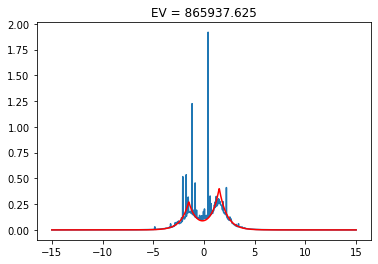

N 29645 Effective N: 1000.0642700195312


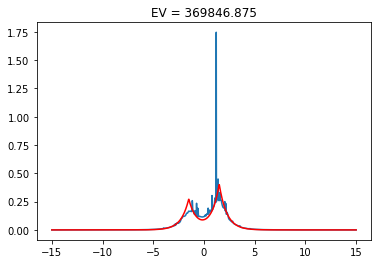

N 5147 Effective N: 1000.0658569335938


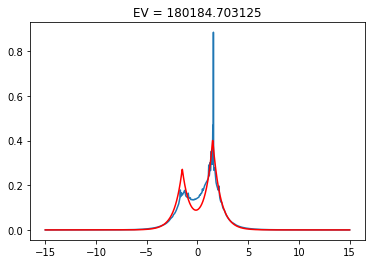

N 2174 Effective N: 1000.5818481445312


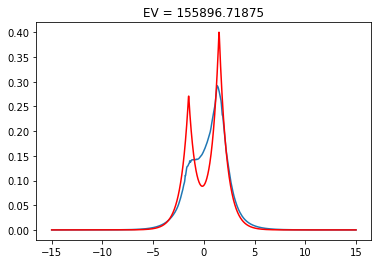

N 1964 Effective N: 1000.3833618164062


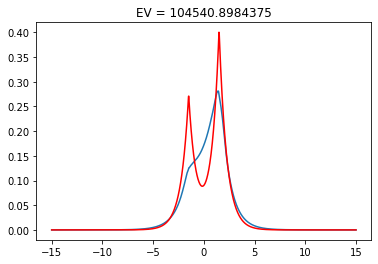

N 2461 Effective N: 1000.8333129882812


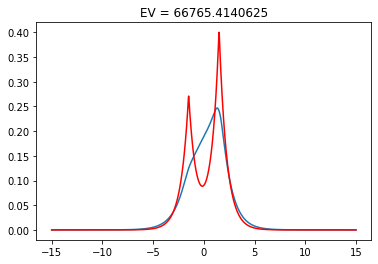

N 3140 Effective N: 1000.583740234375


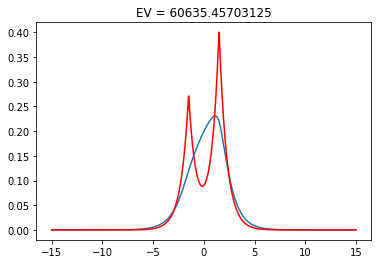

N 4251 Effective N: 1000.6100463867188


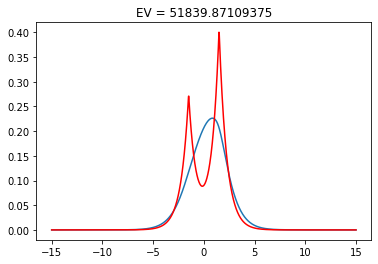

N 5637 Effective N: 1000.7860107421875


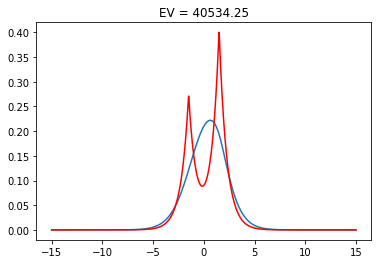

N 7891 Effective N: 1000.1734008789062


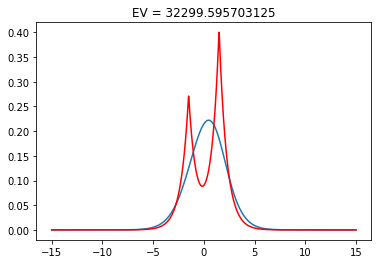

N 10653 Effective N: 1000.0476684570312


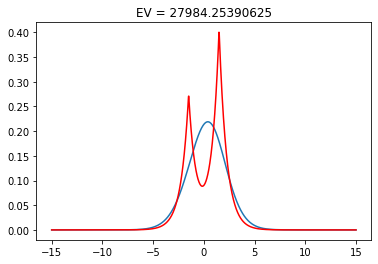

N 15469 Effective N: 1000.0509643554688


In [ ]:
exps_MC = [MC_integrate(conf, 1000, random_poly, True) for conf in configs]

In [ ]:
plt.loglog(np.logspace(0,1,10,),np.abs(np.array(exps_MC)),'o-')
plt.hlines(random_poly_expectation, 1,100,color='r')
plt.xlabel("$\lambda$");
plt.ylabel("EV")
plt.show()

See the convergence towards a single value with increasing N

In [ ]:
exps_MC_conv = [MC_integrate(configs[2], int(n), random_poly) for n in np.logspace(2,4,10)]
plt.plot(exps_MC_conv)

## Now check out the variance as a function of $\lambda$

In [ ]:
def get_mean_sq(conf, fn, n_runs = 50, N=100):
    sq_diffs = []
    for i in range(n_runs):
        estimate = MC_integrate(conf, N, fn)
        sq_diffs.append((estimate)**2)
    return np.mean(sq_diffs)

In [ ]:
variances = np.array([get_mean_sq(c,random_poly) for c in configs]) - np.array(exps_MC)**2

In [ ]:
plt.semilogx(np.logspace(0,2,20,),np.abs(np.array(exps_MC)-random_poly_expectation))
# plt.plot(variances)
plt.xlabel("$\lambda$");
plt.ylabel("Bias")
plt.show()
plt.semilogx(np.logspace(0,2,20,),variances)
# plt.plot(variances)
plt.xlabel("$\lambda$");
plt.ylabel("Variance")
plt.show()